In [ ]:
from google.colab import files
files.upload()#n

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"lolislayer","key":"a15ff208705219768b55d5df9ec691bd"}'}

In [ ]:
!pip install -q kaggle#n

In [ ]:
api_token = {"username":"lolislayer","key":"a15ff208705219768b55d5df9ec691bd"}
import json
import zipfile
import os
!mkdir -p ~/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pip install pytesseract
!sudo apt install tesseract-ocr

In [ ]:
!cp kaggle.json ~/.kaggle/#n

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kaggle
import cv2
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import pytesseract
from google.colab.patches import cv2_imshow
%config InlineBackend.figure_format = 'svg' # using svg makes plots clearer
%matplotlib inline

In [ ]:
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

In [ ]:
plt.rcParams["figure.figsize"] = (13.0,8.0)

In [ ]:
!kaggle datasets download -d thomasqazwsxedc/alphabet-characters-fonts-dataset
if not os.path.exists("/content/competitions/alphabet-characters-fonts-dataset"):
    os.makedirs("/content/competitions/alphabet-characters-fonts-dataset")
os.chdir('/content/competitions/alphabet-characters-fonts-dataset')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

 98% 550M/559M [00:12<00:00, 81.4MB/s]
100% 559M/559M [00:12<00:00, 47.5MB/s]


In [ ]:
def load_data(h = False):
    if h:   
        temp = np.load('/content/competitions/alphabet-characters-fonts-dataset/character_fonts (with handwritten data).npz')
        return temp['images'], temp['labels']
    else: 
        temp = np.load('/content/competitions/alphabet-characters-fonts-dataset/character_font.npz')
        return temp['images'], temp['labels']

In [ ]:
images, labels = load_data() # loading data without handwritten digits
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')
imagess = images

Images shape: (389765, 32, 32)
Labels shape: (389765,)


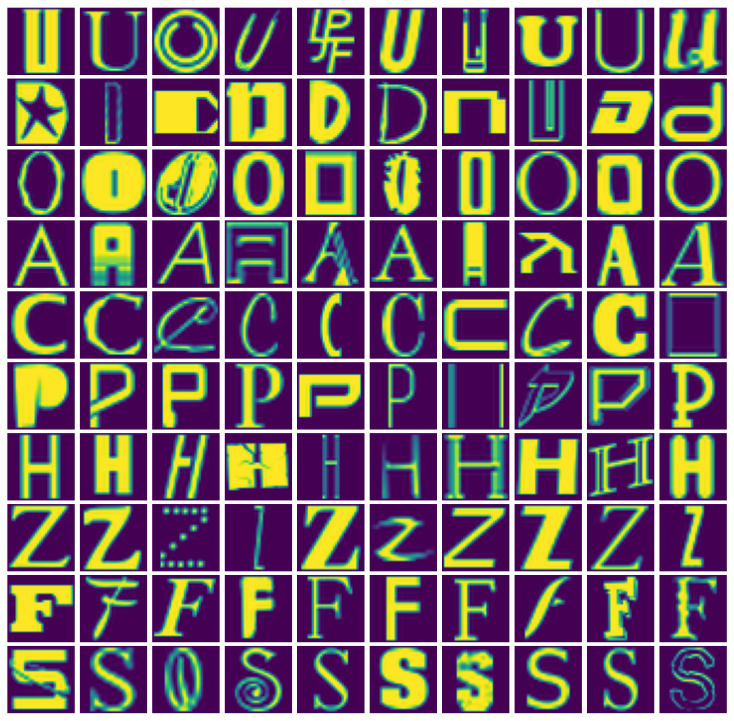

In [ ]:
# showing data
# # of rows, # of columns, organzied, tight layout
# set organized to true to get an alphabet for each row
def show_images(nrows=10,ncols = 10, o = True, t= False):
    # organized, random, same
    plt.close()
    fig = plt.figure(figsize=(13,13)) # Notice the equal aspect ratio
    ax = [plt.subplot(nrows,ncols,i+1) for i in range(nrows*ncols)]
    if not o:
        temp = np.random.choice(images.shape[0],nrows*ncols,replace=False)
        for i,a in enumerate(ax):
            a.imshow(images[temp[i]])
            a.axis('off')
            a.set_aspect('equal')
    else:
        assert nrows <= 26
        temp = np.random.choice(np.arange(26),ncols,replace=False)
        count = -1
        l = []
        for i in temp:
            l.append(np.random.choice(np.argwhere(labels == i).ravel(),ncols, replace=False))
        for i,a in enumerate(ax):
            if i%(ncols) == 0:
                count+=1
            a.imshow(images[l[count][i%ncols]])
            a.axis('off')
            a.set_aspect('equal')
    if t:
        fig.tight_layout()
    fig.subplots_adjust(wspace=0.0, hspace=0.05)
    fig.show()
show_images()

In [ ]:
#change shape and split data
images = images.reshape(-1,1024)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.001, random_state=42)

In [ ]:
print(images.shape,labels.shape)

(389765, 1024) (389765,)


In [ ]:
#z-score  normalize
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
type(x_train)

numpy.ndarray

In [ ]:
#find label
def evaluateKNN_single(k, x_train, y_train, data):
  w = np.linalg.norm(x_train - data, axis = 1) #euclide distance
  knn = np.argpartition(w,k)[:k] #top k distance
  y_most = Counter(y_train[knn]).most_common(1)[0][0] #get top 1 label 
  return y_most
#find label of img
def single_recog(img):
  if img is None:
    return ' '
  else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#change to gray 
    if img[0][0] > 128:
      img = cv2.threshold(img,128,255,1)#white->black / change img to b-w img
    else:
      img = cv2.threshold(img,128,255,0)#black->white
    imgs = img[1]
    imgs = cv2.resize(imgs,(32,32))#resize equal to dataset
    imgs = imgs.reshape(-1,1024)
    imgs = scaler.transform(imgs)
    re = evaluateKNN_single(15,x_train,y_train,imgs)
    return re
#accuraccy
def evaluateKNN(k, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    correct = sum(map(lambda x: evaluateKNN_single(k, x_train, y_train, x[0]) == x[1], zip(x_test, y_test)))
    print(f'Test accuracy with k={k}: {correct/len(y_test)*100:.4f}% ({correct}/{len(y_test)})')
    return correct
#get char
def convert_word(img):
  word = 'abcdefghijklmnopqrstuvwxyz'
  label = single_recog(img)
  return word[label]
#cconvert img to text and detection
def image_to_text(img):
  he,we,v = img.shape
  color = 0
  #gray
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #binary-threshold
  if gray[0][0] > 128: #for white background
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  else: #for black background
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
      color = 1
  imgs = []
  text = ''
  # get counter
  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #contour h
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  #list of bounding box
  boun =[]
  for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    boun.append((x,y,w,h))
  #sorted by position y-priority and x
  (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boun),
		key=lambda b:b[1][1]/he*2+b[1][0]/we, reverse=False)) #x,y,w,h b = 
  #draw box and get text
  for cont in boundingBoxes:
    x,y,w,h = cont
    image = img[y-5:y+h+5,x-5:x+w+5]
    imgs.append(image)
    #cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 1)
    c = convert_word(image)
    text = text + c
    #print(c)
    if color == 0:
      cv2.putText(img, c, (x+5,y), cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)
    else:
      cv2.putText(img, c, (x+5,y), cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
  print(text)
  plt.imshow(img)

In [ ]:
evaluateKNN(5)

Test accuracy with k=5: 78.9744% (308/390)


308

In [ ]:
!wget https://www.designyourway.net/diverse/4/csstype/ArFvk.jpg -O text.jpg
img = cv2.imread('text.jpg')

--2021-02-24 15:14:12--  https://www.designyourway.net/diverse/4/csstype/ArFvk.jpg
Resolving www.designyourway.net (www.designyourway.net)... 45.33.101.94
Connecting to www.designyourway.net (www.designyourway.net)|45.33.101.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10621 (10K) [image/jpeg]
Saving to: ‘text.jpg’

text.jpg            100%[===================>]  10.37K  --.-KB/s    in 0s      

2021-02-24 15:14:13 (204 MB/s) - ‘text.jpg’ saved [10621/10621]



In [ ]:
img = cv2.imread('/content/unnoise.png')

In [ ]:
print(pytesseract.image_to_string(img))

SUPER SEATAL GOKAIGER
DEKARANGER 60 ONGER



nmfgrsawmnaijaokaikjgcrdckakrawoncraoowoncr


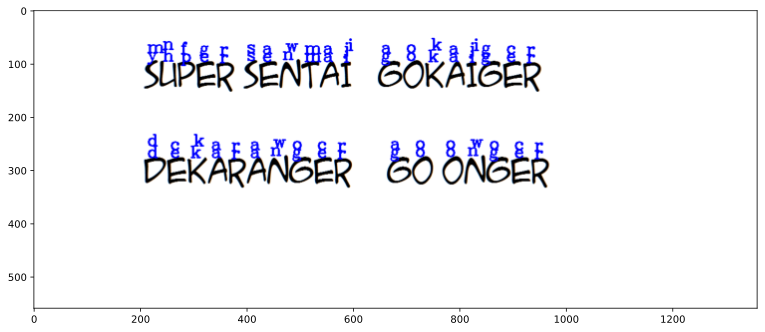

In [ ]:
image_to_text(img)

In [ ]:
"""
1. Đề tài
2. Ý tưởng 
- Sử dụng KNN
- cv2 để xử lý ảnh và bounding box
3. dataset(show) - kaggle
4. Xử lý dataset
- reshape 
- chia data với tỉ lệ 99,9% - 0,1%
- normalize
5. Thuật toán nhận diện chữ
- KNN -singel-recog(code + label A-0,B-2...):
 + biến ảnh thành đen trắng + resize 
 + reshape + normalize
 + dùng KNN để nhận về label
6. Detection 
- cv2.findContour - tìm viền của vật thể và bounding box
* vấn đề : hàm ko trả về theo thứ tự từ trái sang phải, trên xuống dưới
-> xử lý vấn đề x/w + y/h*2 <- sắp xếp theo
7. Show kết quả và so sánh với tess
"""

In [ ]:
https://superdevresources.com/wp-content/uploads/2016/03/photoshop-text-effect-tutorials-1280x720.png
https://yourmarketingbff.com/wp-content/uploads/2017/04/using-clipping-mask-with-text-in-adobe-photoshop.jpg
https://twibbr.com/wp-content/uploads/2020/11/Glitch-Effect-in-LESS.png
https://www.designyourway.net/diverse/4/csstype/ArFvk.jpg
https://mk0slidecowixjpdg2l0.kinstacdn.com/wp-content/uploads/2018/04/Setting-Up-The-Slide-Text-1000x563.jpg

In [ ]:
# le,he,d = img.shape
# le,he

(559, 1359)

In [ ]:
# data = pytesseract.image_to_boxes(img)
# data = data.splitlines()

In [ ]:
# data

In [ ]:
# imgs = []
# for p in data:
#   p = p.split(' ')
#   c,x,y,w,h = p[0],int(p[1]),int(p[2]),int(p[3]),int(p[4])
#   #cv2.rectangle(img,(x,le-y),(w,le-h),(0,0,255),1)
#   #cv2.putText(img, c, (x,le-y+25), cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(0, 255, 0), thickness=1)
#   img_cut = img[le-y:le-h,x:w]
#   imgs.append(img_cut)

In [ ]:
# b = ''
# for pic in imgs:
#   b = b + convert_word(pic)
#   #pics = cv2.resize(pic,(32,32))
#   #cv2_imshow(pics)
#   cv2_imshow(pic)
# print(b)